<a href="https://colab.research.google.com/github/Geu-Pro2023/Streamlit-ML/blob/main/dreamers_Team_weather_classificati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weather Condition Classification using Modern CNN Architecture**

This notebook implements a weather classification system using transfer learning with MobileNetV2 and custom CNN layers to achieve high accuracy on the multi-class weather dataset.

## **Import Libraries**

In [13]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

## **Configuration and Data Paths**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data paths
TRAIN_DIR = '/content/drive/MyDrive/indabax-south-sudan/weather_dataset'
TEST_DIR = '/content/drive/MyDrive/indabax-south-sudan/test'

# Class names
CLASS_NAMES = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Training directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

Training directory: /content/drive/MyDrive/indabax-south-sudan/weather_dataset
Test directory: /content/drive/MyDrive/indabax-south-sudan/test
Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Number of classes: 4


## **Display Dataset**


Class Distribution:
Cloudy: 300 images
Shine: 263 images
Rain: 215 images
Sunrise: 357 images


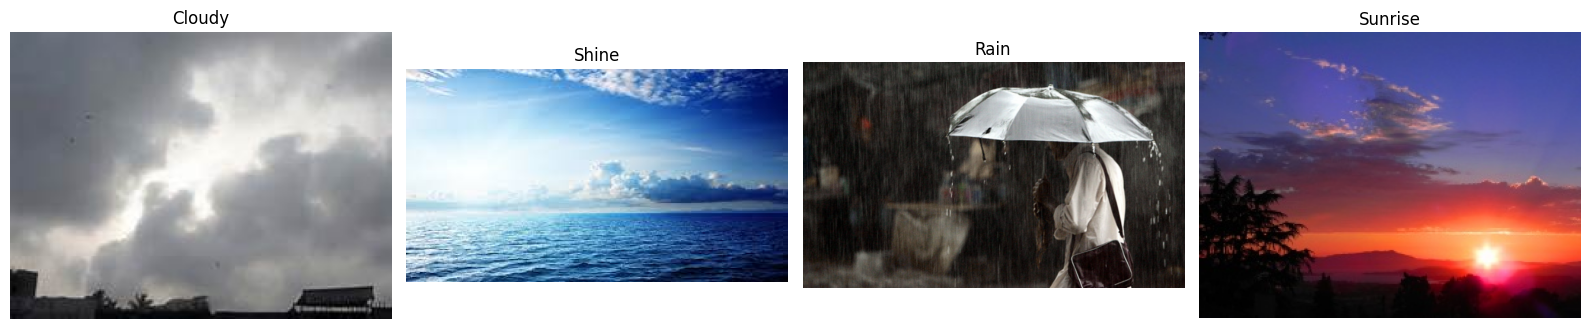

In [43]:
# Load and Explore Dataset
def explore_dataset():
    """Explore the dataset structure and show one sample image per class"""
    train_dir = os.path.join(CONFIG["data_path"])

    # Verify the directory exists
    if not os.path.exists(train_dir):
        print(f"Error: Directory not found at {train_dir}")
        print("Please verify your CONFIG['data_path'] is correct")
        return

    # Print class distribution
    print("\nClass Distribution:")
    for cls in CONFIG["class_names"]:
        cls_path = os.path.join(train_dir, cls)
        if os.path.exists(cls_path):
            num_images = len(os.listdir(cls_path))
            print(f"{cls}: {num_images} images")
        else:
            print(f"Warning: Class directory not found - {cls_path}")

    # Display one image per class
    num_classes = len(CONFIG["class_names"])
    plt.figure(figsize=(4 * num_classes, 4))

    for i, cls in enumerate(CONFIG["class_names"]):
        cls_path = os.path.join(train_dir, cls)
        if os.path.exists(cls_path):
            image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                img_path = os.path.join(cls_path, image_files[0])
                try:
                    img = plt.imread(img_path)
                    plt.subplot(1, num_classes, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')
                except Exception as e:
                    print(f"Error loading image from {cls}: {e}")
            else:
                print(f"No image files found in class '{cls}'")
        else:
            print(f"Class directory does not exist: {cls_path}")

    plt.tight_layout()
    plt.show()

CONFIG = {
    "data_path": "/content/drive/MyDrive/indabax-south-sudan/weather_dataset",
    "class_names": ["Cloudy", "Shine", "Rain", "Sunrise"]
}

# Run the function
explore_dataset()


## **Data Analysis and Visualization**

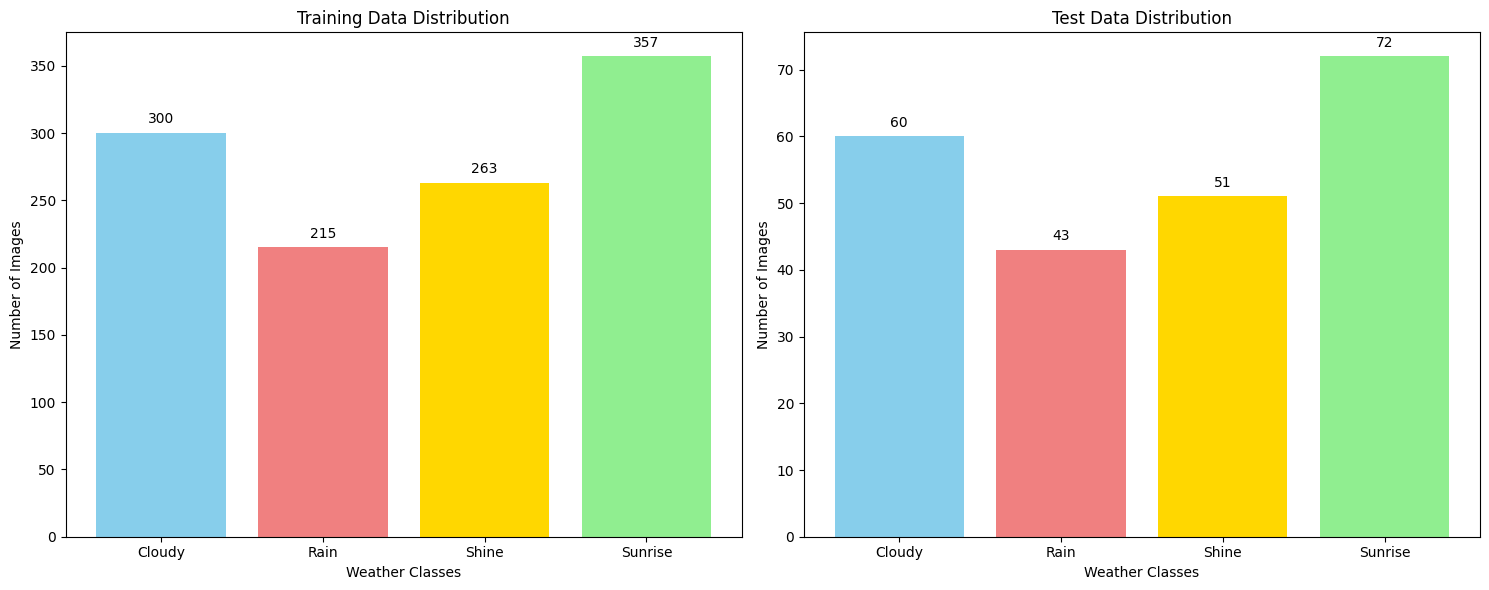

Training Data:
Cloudy: 300 images
Rain: 215 images
Shine: 263 images
Sunrise: 357 images

Test Data:
Cloudy: 60 images
Rain: 43 images
Shine: 51 images
Sunrise: 72 images


In [16]:
# Count images in each class for training data
train_counts = {}
for class_name in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    train_counts[class_name] = len(os.listdir(class_path))

# Count images in each class for test data
test_counts = {}
for class_name in CLASS_NAMES:
    class_path = os.path.join(TEST_DIR, class_name)
    test_counts[class_name] = len(os.listdir(class_path))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training data distribution
ax1.bar(train_counts.keys(), train_counts.values(), color=['skyblue', 'lightcoral', 'gold', 'lightgreen'])
ax1.set_title('Training Data Distribution')
ax1.set_ylabel('Number of Images')
ax1.set_xlabel('Weather Classes')
for i, v in enumerate(train_counts.values()):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom')

# Test data distribution
ax2.bar(test_counts.keys(), test_counts.values(), color=['skyblue', 'lightcoral', 'gold', 'lightgreen'])
ax2.set_title('Test Data Distribution')
ax2.set_ylabel('Number of Images')
ax2.set_xlabel('Weather Classes')
for i, v in enumerate(test_counts.values()):
    ax2.text(i, v + 1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Training Data:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest Data:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

## **Data Preprocessing and Augmentation**

In [17]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 909 images belonging to 4 classes.
Found 226 images belonging to 4 classes.
Found 226 images belonging to 4 classes.
Training samples: 909
Validation samples: 226
Test samples: 226
Class indices: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}


## **Model Architecture - Transfer Learning with MobileNetV2**

In [18]:
def create_model():
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

# Create model
model, base_model = create_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Model created successfully!
Total parameters: 3,053,380
Trainable parameters: 791,812


## **Training Callbacks**

In [19]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

### **Phase 1: Train Classification Head**

In [20]:
print("Phase 1: Training classification head with frozen base model...")

# Train the model
history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("Phase 1 training completed!")

Phase 1: Training classification head with frozen base model...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 346s 12s/step - accuracy: 0.5766 - loss: 1.2858 - val_accuracy: 0.8053 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8882 - loss: 0.3297 - val_accuracy: 0.8761 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8997 - loss: 0.2705 - val_accuracy: 0.8938 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9079 - loss: 0.2842 - val_accuracy: 0.8938 - val_loss: 0.2826 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9105 - loss: 0.2500 - val_accuracy: 0.9071 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9226 - loss: 0.1922 - val_accuracy: 0.8850 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━

### **Phase 2: Fine-tuning**

In [21]:
print("Phase 2: Fine-tuning the entire model...")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2 training completed!")

Phase 2: Fine-tuning the entire model...
Trainable parameters after unfreezing: 3,015,684
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 273s 8s/step - accuracy: 0.7900 - loss: 0.8591 - val_accuracy: 0.6681 - val_loss: 1.5726 - learning_rate: 1.0000e-04
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 220s 8s/step - accuracy: 0.9170 - loss: 0.2532 - val_accuracy: 0.7522 - val_loss: 1.4612 - learning_rate: 1.0000e-04
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9333 - loss: 0.1922 - val_accuracy: 0.8053 - val_loss: 0.8178 - learning_rate: 1.0000e-04
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 221s 8s/step - accuracy: 0.9651 - loss: 0.1054 - val_accuracy: 0.7478 - val_loss: 1.1110 - learning_rate: 1.0000e-04
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 268s 8s/step - accuracy: 0.9512 - loss: 0.1283 - val_accuracy: 0.8009 - val_loss: 1.0147 - learning_rate: 1.0000e-04
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step - accuracy: 0.9658 - loss: 0.0904 - val_accuracy: 0.7965 - val_loss: 1.1789 - learni

## **Training History Visualization**

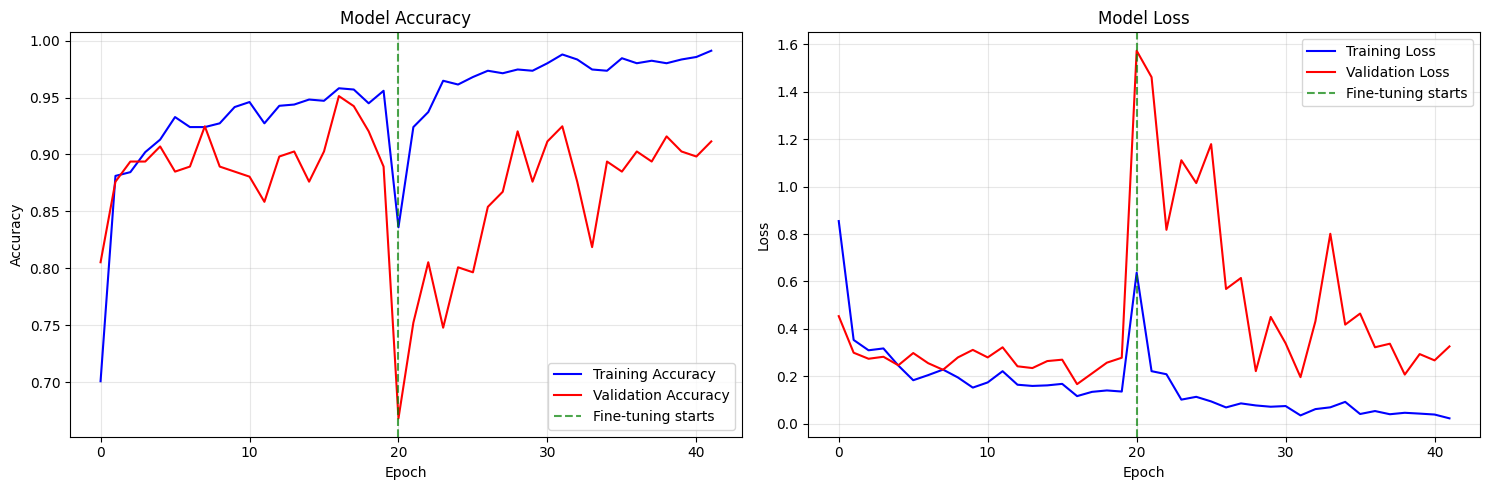

Final Training Accuracy: 0.9912
Final Validation Accuracy: 0.9115


In [22]:
# Combine training histories
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history_phase1, history_phase2)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(combined_history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(combined_history['val_accuracy'], label='Validation Accuracy', color='red')
ax1.axvline(x=len(history_phase1.history['accuracy']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(combined_history['loss'], label='Training Loss', color='blue')
ax2.plot(combined_history['val_loss'], label='Validation Loss', color='red')
ax2.axvline(x=len(history_phase1.history['loss']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

## **Model Evaluation on Test Set**

In [23]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

Evaluating model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.9592 - loss: 0.1238

Test Accuracy: 0.9646 (96.46%)
Test Loss: 0.0961
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.91      0.97      0.94        60
        Rain       1.00      1.00      1.00        43
       Shine       0.98      0.88      0.93        51
     Sunrise       0.99      1.00      0.99        72

    accuracy                           0.96       226
   macro avg       0.97      0.96      0.96       226
weighted avg       0.97      0.96      0.96       226



## **Confusion Matrix**

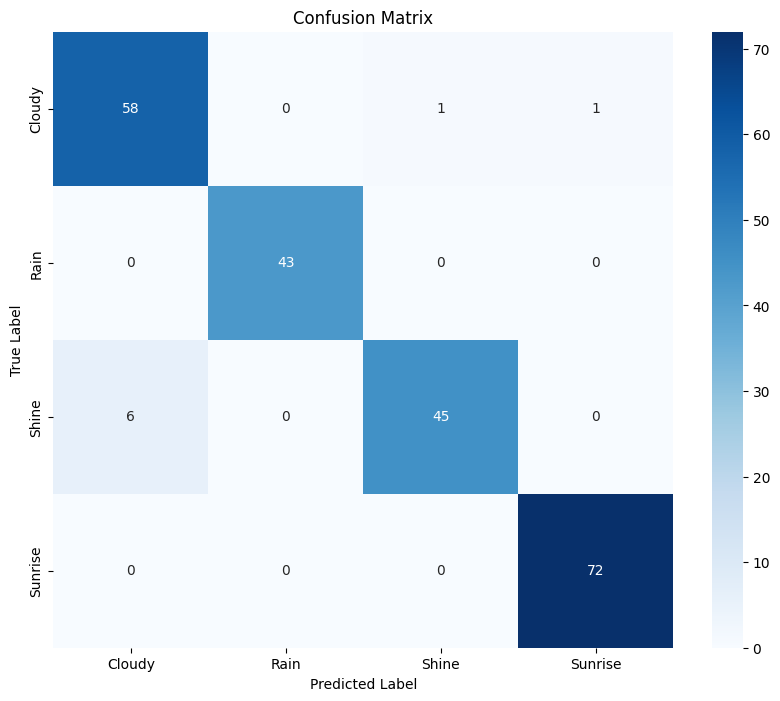


Per-class Accuracy:
Cloudy: 0.9667 (96.67%)
Rain: 1.0000 (100.00%)
Shine: 0.8824 (88.24%)
Sunrise: 1.0000 (100.00%)


In [24]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

## **Sample Predictions Visualization**

Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


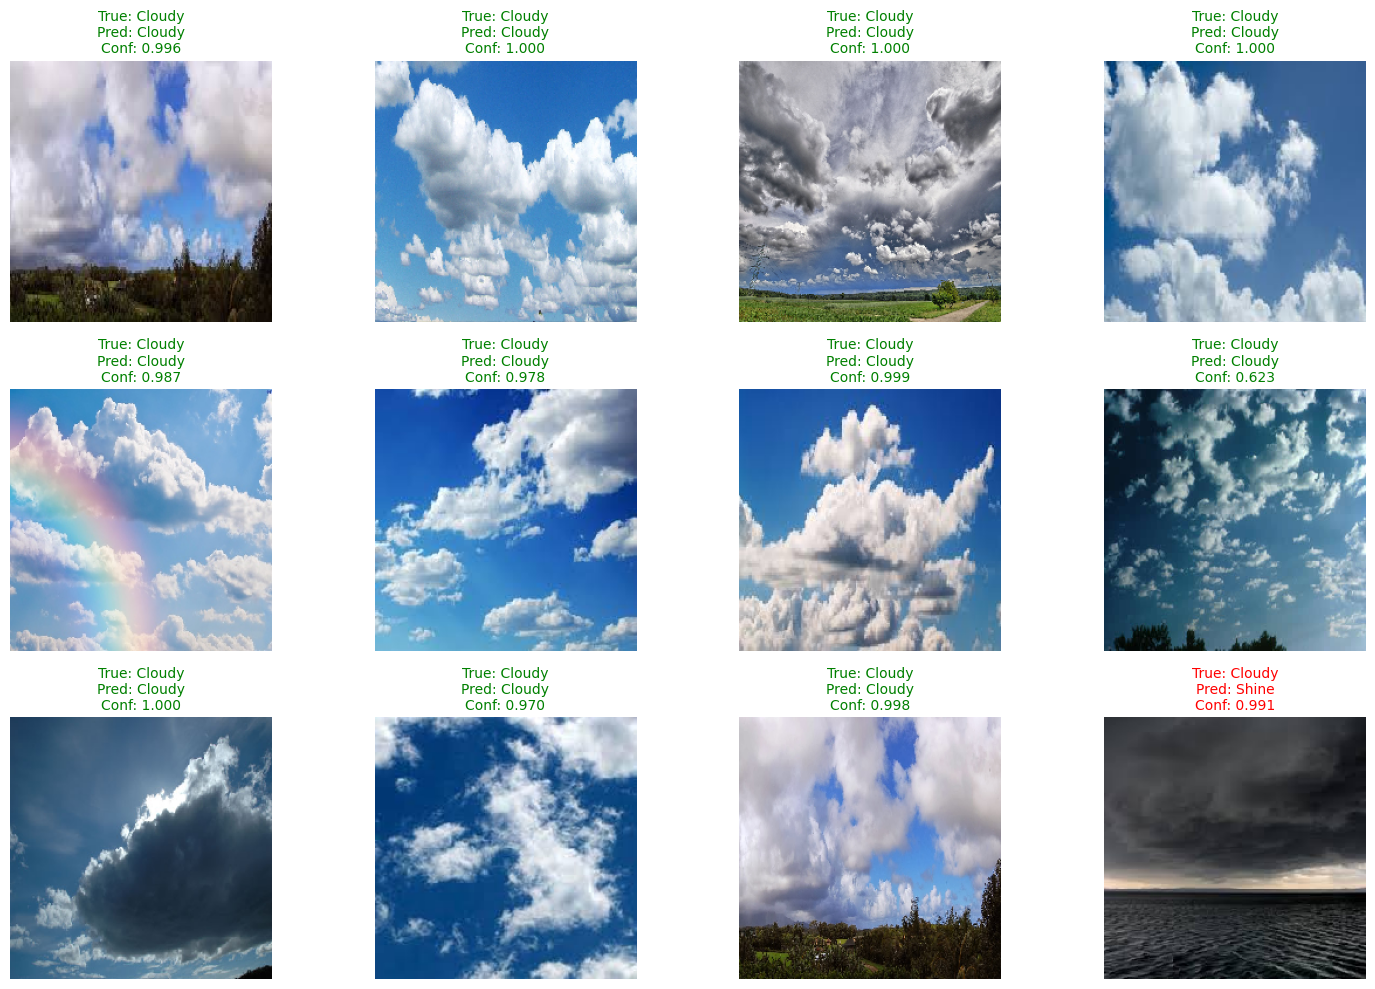

In [25]:
# Function to display sample predictions
def plot_sample_predictions(generator, model, num_samples=12):
    generator.reset()
    batch_images, batch_labels = next(generator)

    predictions = model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)

    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(batch_images[i])

        true_label = class_names[true_classes[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]]

        color = 'green' if true_classes[i] == predicted_classes[i] else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("Sample Predictions:")
plot_sample_predictions(test_generator, model)

## **Model Summary and Results**

In [26]:
print("=" * 60)
print("WEATHER CLASSIFICATION MODEL RESULTS")
print("=" * 60)
print(f"Architecture: Transfer Learning with MobileNetV2")
print(f"Input Size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {validation_generator.samples}")
print(f"Test Samples: {test_generator.samples}")
print("-" * 60)
print("PERFORMANCE METRICS:")
print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("=" * 60)

if test_accuracy >= 0.97:
    print("TARGET ACHIEVED: Model reached 97%+ accuracy!")
else:
    print(f"Current accuracy: {test_accuracy*100:.2f}% (Target: 97%)")

print("=" * 60)

WEATHER CLASSIFICATION MODEL RESULTS
Architecture: Transfer Learning with MobileNetV2
Input Size: 224x224x3
Number of Classes: 4
Total Parameters: 3,053,380
Training Samples: 909
Validation Samples: 226
Test Samples: 226
------------------------------------------------------------
PERFORMANCE METRICS:
Final Training Accuracy: 0.9912 (99.12%)
Final Validation Accuracy: 0.9115 (91.15%)
Test Accuracy: 0.9646 (96.46%)
Test Loss: 0.0961
Current accuracy: 96.46% (Target: 97%)


### **Save the Trained Model**

In [27]:
#Save the model
model.save('ًdreamers_Weather Model.h5')

### **Final Prediction Using Test Dataset**

In [35]:
# Set the image name to predict
image_name = 'cloudy101.jpg'  # Change this to any image name

In [34]:
# Load the saved model
loaded_model = tf.keras.models.load_model('ًdreamers_Weather Model.h5')

# Define classes
classes = CLASS_NAMES

# Find image by name across all test subdirectories
image_path = None
for class_folder in classes:
    search_path = f'test/{class_folder}/{image_name}'
    if os.path.exists(search_path):
        image_path = search_path
        break

if image_path is None:
    print(f"Image '{image_name}' not found in test directory")
else:
    # Make prediction
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0

    predictions = loaded_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = classes[tf.argmax(score)]

    # Display image with prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    print(f"Prediction: {predicted_class}")

Image 'cloudy101.jpg' not found in test directory


## **Save Submission File**

In [37]:
# Load model
model = tf.keras.models.load_model('ًdreamers_Weather Model.h5')

# Predict
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_indices = np.argmax(predictions, axis=1)

# Map indices to class names (e.g., 0 -> 'Cloudy')
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
predicted_labels = [index_to_class[idx] for idx in predicted_indices]

# Create submission DataFrame with id starting from 1
submission_df = pd.DataFrame({
    'id': range(1, len(predicted_labels) + 1),
    'label': predicted_labels
})

# Save the file
submission_df.to_csv('submission.csv', index=False)
print("Correctly formatted submission file created: submission.csv")


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Correctly formatted submission file created: submission.csv
